以解泊松方程为例，介绍有限元素方法的思路  
根据$\vec{E}=-\nabla\varphi$和$\nabla\cdot\vec{E}=\frac{\rho}{\varepsilon}$，可以得到描述电势$\varphi$和电荷密度$\rho$的关系的泊松方程  
$$\nabla^2\varphi=-\frac{\rho}{\varepsilon}$$
这个方程也可以通过拉格朗日量得到，如果将$\varphi$视为广义位移，则拉格朗日量为  
$$L=\frac{\varepsilon}{2}|\nabla\varphi|^2-\rho\varphi$$
将这个拉格朗日量代入欧拉-拉格朗日方程，就可以得到上面的泊松方程  
欧拉-拉格朗日方程是根据作用量的变分为0推导得到的，因此泊松方程等价于  
$$\delta S(\varphi)=\delta\left(\int_{V}{L(\varphi)}dV\right)=0$$
对泛函变分的严格求解十分困难，但是可以把求解区域$V$分成很多小单元  
总泛函等于每个小单元的泛函之和，泛函的变分近似为对每个小单元求导  
从而可以得到泛函变分等于0的近似解，这个解也是等价的微分方程的近似解  
这个思路也可以应用到求解其他微分方程上：  
找到微分方程对应的泛函，对求解区域进行划分，求解泛函变分等于0的近似解

用有限元方法计算方程的数值解  
$$
\left \{
    {\begin{array}{cc}
        \frac{\partial^2 \phi}{\partial x^2}+\frac{\partial^2 \phi}{\partial y^2}=0,0\leq x,y\leq1 \\
        \phi(x,0)=\phi(x,1)=0,\phi(0,y)=\phi(1,y)=1 \\
    \end{array}}
\right .
$$

计算格式建立的过程比较复杂，这里直接使用课本上的结论

In [1]:
import numpy as np
import matplotlib.pyplot as plt

对求解区域做以下形式的三角形元素划分，这样划分可以让后面的流程相对简单

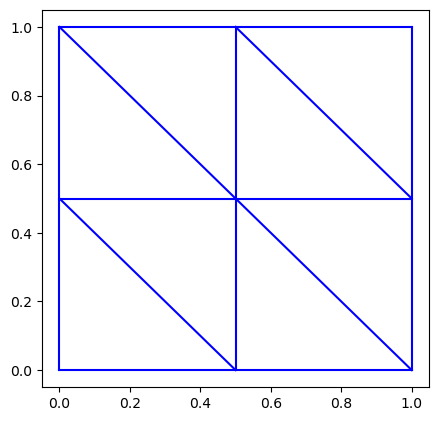

In [2]:
plt.figure(figsize=(5, 5), dpi=100)
plt.plot([0, 0], [0, 1], color='blue')
plt.plot([0, 1], [1, 1], color='blue')
plt.plot([1, 1], [1, 0], color='blue')
plt.plot([1, 0], [0, 0], color='blue')
plt.plot([1/2, 1/2], [0, 1], color='blue')
plt.plot([0, 1], [1/2, 1/2], color='blue')
plt.plot([1/2, 1], [1, 1/2], color='blue')
plt.plot([0, 1/2], [1/2, 0], color='blue')
plt.plot([0, 1], [1, 0], color='blue')
plt.show()

用矩阵记录求解区域的内部节点和边界节点

In [3]:
# 求解区域的范围
x_range = [0.0, 1.0]
y_range = [0.0, 1.0]

# 划分的步长
h = 0.1

# 每一个点的坐标
x = np.arange(x_range[0], x_range[1]+h, h)
y = np.arange(y_range[0], y_range[1]+h, h)

# 格点数目
x_n_grid = len(x)
y_n_grid = len(y)

# 边界点和求解区域，边界点标记为True，待求点标记为False
area = np.full(shape=(x_n_grid, y_n_grid), fill_value=True)
area[1: -1, 1: -1] = np.full(shape=(x_n_grid-2, y_n_grid-2), fill_value=False)

print(area)

[[ True  True  True  True  True  True  True  True  True  True  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True False False False False False False False False False  True]
 [ True  True  True  True  True  True  True  True  True  True  True]]


对每一个节点编号，内部节点在前，边界节点在后

In [4]:
# 建立编号矩阵，其中的每一个编号对应区域中的一个节点
index_matrix = np.zeros((x_n_grid, y_n_grid), dtype=int)
k = 0

# 先对内部节点编号
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if not area[i, j]:
            index_matrix[i, j] = k
            k += 1
            
# 内部节点数            
n_inner = k

# 然后对边界节点编号
for i in range(x_n_grid):
    for j in range(y_n_grid):
        if area[i, j]:
            index_matrix[i, j] = k
            k += 1

# 边界节点数        
n_edge = k - n_inner
            
print(index_matrix)

[[ 81  82  83  84  85  86  87  88  89  90  91]
 [ 92   0   1   2   3   4   5   6   7   8  93]
 [ 94   9  10  11  12  13  14  15  16  17  95]
 [ 96  18  19  20  21  22  23  24  25  26  97]
 [ 98  27  28  29  30  31  32  33  34  35  99]
 [100  36  37  38  39  40  41  42  43  44 101]
 [102  45  46  47  48  49  50  51  52  53 103]
 [104  54  55  56  57  58  59  60  61  62 105]
 [106  63  64  65  66  67  68  69  70  71 107]
 [108  72  73  74  75  76  77  78  79  80 109]
 [110 111 112 113 114 115 116 117 118 119 120]]


初始化所有的三角形元素  
注意画图和矩阵表示的不同  
画图时x为横坐标，y为纵坐标，(0,0)位于左下方  
矩阵中x为行标，y为列标，[0,0]位于左上方  
图中从左上到右下的划分在矩阵中是从右上到左下  
除去矩阵左侧1列和下方1行，每个节点向左下划分2个三角形元素  
可以没有重复地得到所有三角形元素

In [5]:
class element:
    def __init__(self, index_list, x_list, y_list):
        # 记录三角形元素的三个节点编号和坐标
        self.index = index_list
        self.x = x_list
        self.y = y_list
        # 计算三角形元素的b和c
        self.b = [self.y[(i+1)%3]-self.y[(i+2)%3] for i in range(3)]
        self.c = [self.x[(i+2)%3]-self.x[(i+1)%3] for i in range(3)]

e_list = []

for i in range(x_n_grid-1):
    for j in range(1, y_n_grid):
        e_list.append(
            element(
                index_list=[index_matrix[i, j], index_matrix[i, j-1], index_matrix[i+1, j-1]],
                x_list=[x[i], x[i], x[i+1]],
                y_list=[y[j], y[j-1], y[j-1]]
            )
        )
        e_list.append(
            element(
                index_list=[index_matrix[i, j], index_matrix[i+1, j-1], index_matrix[i+1, j]],
                x_list=[x[i], x[i+1], x[i+1]],
                y_list=[y[j], y[j-1], y[j]]
            )
        )

print(len(e_list))

200


计算矩阵$K$，矩阵中的元素根据以下公式计算  
$$k_{ll}=\sum_e{k_{ll}^e}$$
$$k_{ij}=\sum_e{k_{ij}^e},i\neq j$$
$$k_{ij}^e=\frac{1}{4\Delta}(b_ib_j+c_ic_j)$$
其中$e$表示包含节点$l$或节点$ij$的三角形元素，$\Delta$是三角形元素的面积，$bc$在整理三角形元素时已经计算过了

In [6]:
Delta = (x_range[1] - x_range[0])*(y_range[1] - y_range[0])/len(e_list)

K = np.zeros((n_inner + n_edge, n_inner + n_edge))

# K矩阵是对称的，所以只计算一半
for e in e_list:
    for i in range(3):
        for j in range(i, 3):
            K[e.index[i], e.index[j]] += (e.b[i]*e.b[j] + e.c[i]*e.c[j])/4/Delta

# 根据对称性补全K矩阵
K += K.T - np.diag(np.diag(K))
print(K)

[[ 4.  -1.   0.  ...  0.   0.   0. ]
 [-1.   4.  -1.  ...  0.   0.   0. ]
 [ 0.  -1.   4.  ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.  -0.5  0. ]
 [ 0.   0.   0.  ... -0.5  2.  -0.5]
 [ 0.   0.   0.  ...  0.  -0.5  1. ]]


将边界条件引入后，需要求解的方程为  
$$(K_{11})(\Phi_1)=(P_1)-(K_{12})(\Phi_2)$$
其中$(\Phi_1)$是需要求解的未知数，$(K_{11})(K_{12})$可以从$K$中截取，本例中显然$(P_1)$的元素都是0  
还需要设置边界条件有关的$(\Phi_2)$，根据前面的编号，前11个边界节点和后11个边界节点的值为1，其他边界节点的值为0

In [7]:
K_11 = K[:n_inner, :n_inner]
K_12 = K[:n_inner, n_inner:]
Phi_2 = np.zeros((n_edge, 1))
Phi_2[:x_n_grid, 0] = Phi_2[-x_n_grid:, 0] = np.ones(x_n_grid)

将方程组写成$Ax=b$的形式

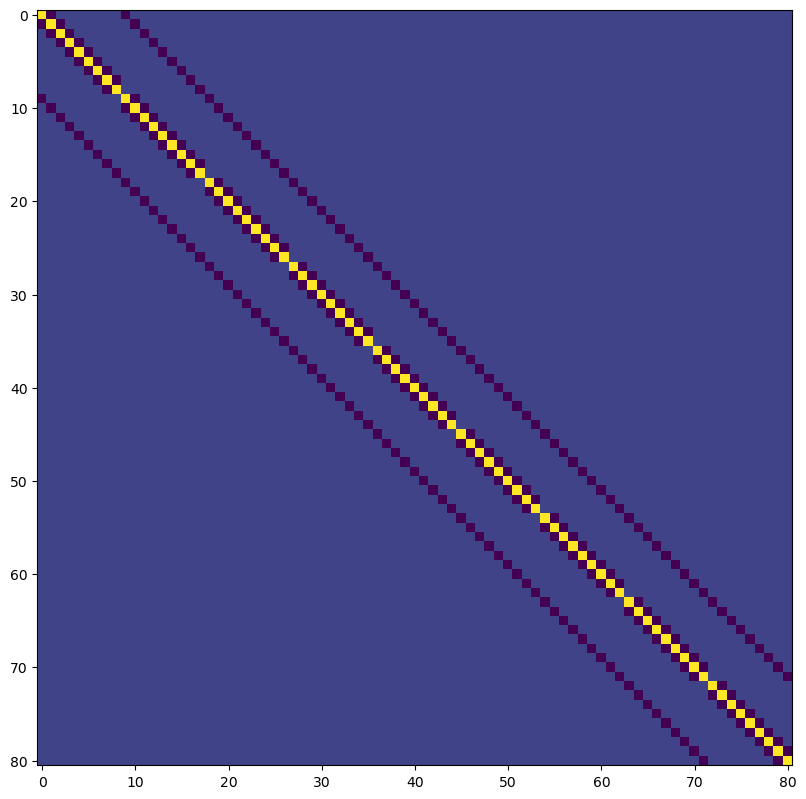

In [8]:
A = K_11
b = -K_12.dot(Phi_2)

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(A)
plt.show()

这里得到的方程组和有限差分法的例子中的方程组是等价的

用超松弛迭代求解，和有限差分法的例子一样，用迭代法求解方程组不用矩阵，而是用以下迭代公式  
$$\phi^{(m+1)}_i=(1-\omega)\phi^{(m)}_i+\frac{\omega}{k_{ii}}\left(-\sum_{j=1}^{i-1}k_{ij}{\phi^{(m+1)}_j}-\sum_{j=i+1}^{n_0}{k_{ij}\phi^{(m)}_j}+p_i\right)$$

In [9]:
# 上面的公式中，大部分k_ij都等于0
# 只需要计算k_ij不为0的部分
# 因此先记录k_ij不为0的编号
k_ij_index = []
for i in range(n_inner):
    k_ij_index.append([])
    for j in range(n_inner+n_edge):
        if K[i, j] != 0 and i != j:
            k_ij_index[-1].append(j)
            
omega = 1.5

# 迭代初值，包含内部节点和边界节点
# 在矩阵运算中Phi是一个列向量
# 在迭代公式中，使用行向量更加简单
# 所以使用行向量记录Phi的每一个值
X = np.hstack((np.ones(n_inner), Phi_2.T[0]))
X0 = X.copy()

# 迭代时只改变内部节点
for i in range(n_inner):
    X[i] = (1-omega)*X[i]
    a = omega/K[i, i]
    for j in k_ij_index[i]:
        X[i] -= a*K[i, j]*X[j]

m = 1

while np.max(abs(X-X0)) > 1e-6:
    X0 = X.copy()
    for i in range(n_inner):
        X[i] = (1-omega)*X[i]
        a = omega/K[i, i]
        for j in k_ij_index[i]:
            X[i] -= a*K[i, j]*X[j]
    m += 1
    
print("Converges in %d steps"%m)

Converges in 34 steps


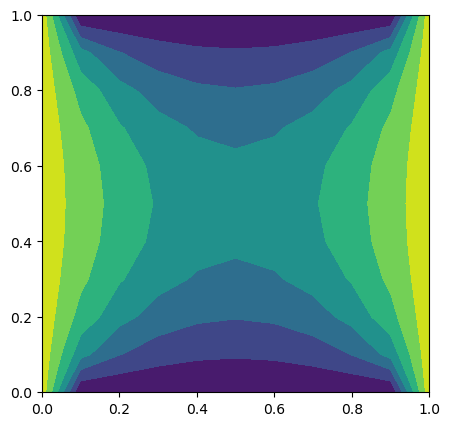

In [10]:
Phi = X.copy()

value_matrix = np.zeros((x_n_grid, y_n_grid))

# 将解填入求解区域中
for i in range(x_n_grid):
    for j in range(y_n_grid):
        value_matrix[i, j] = Phi[index_matrix[i, j]]
            
fig = plt.figure(figsize=(5, 5), dpi=100)
plt.contourf(x, y, value_matrix.T)
plt.show()

以上内容只是演示有限元素方法的流程，不是最优解法。